In [2]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from gym.utils.env_checker import check_env as checker_gym
from stable_baselines3.common.env_checker import check_env as checker_baselines3
import torch
import torch.nn as nn
from stable_baselines3.common.logger import configure
import random
import matplotlib 
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Optimization using Reinforcement Learning and Heuristic Methods

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [3]:
# set training period
start_date = date(2019, 1, 8) # inclusive
end_date = date(2019, 3, 12) # exclusive
start_week = 1
end_week = 9

# set testing period
start_date_simulation = date(2019, 3, 12) # inclusive
end_date_simulation = date(2019, 3, 26) # exclusive
start_week_simulation = 10
end_week_simulation = 11

# calculate number of days to learn
nr_iterations = (end_date - start_date).days

# calculate number of days to simulate
nr_iterations_simulation = (end_date_simulation - start_date_simulation).days

# Load data for simulation

The tutorial conducts a case study on a subset of 15 vehicles.

### Car-sharing stations

In [4]:
# get station geodata
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")

# create necessary features
stations["x"] = stations.geom.x.values
stations["y"] = stations.geom.y.values

# create spatial index
stations.sindex

# show data structure
#stations.head()

### Vehicle information

In [5]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no limit 15 offset 60"
vehicles = pd.read_sql(sql, engine)

# save vehicle IDs
vehicle_nr_list = vehicles["vehicle_no"].tolist()

# show data structure
#vehicles.head()

### Reservations

In [6]:
# get daily reservations for training period including pre processing, save daily tables dict for fast data access during simulation
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations, vehicle_nr_list) 
    reservations = pd.read_sql(sql, engine)
    reservations = reservations[reservations['vehicle_no'].isin(vehicle_nr_list)]
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta     

# show data structure within dict
#reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

In [7]:
# get daily reservations for testing period including pre processing, save daily tables dict for fast data access during simulation
delta = timedelta(days=1)
reservations_dict_simulation = {}
start_date_reservations = start_date_simulation
while start_date_reservations <= end_date_simulation:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}'
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations, vehicle_nr_list)
    reservations = pd.read_sql(sql, engine)
    reservations = reservations[reservations['vehicle_no'].isin(vehicle_nr_list)]
    reservations_dict_simulation[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta
    
# show data structure within dict
#reservations_dict_simulation[(start_date_simulation).strftime('%Y-%m-%d')].head()

### Electicity prices for charging

In [8]:
# get charging costs data for training period
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)
sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
charging_costs = pd.read_sql(sql, engine)

# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

# show data structure
#charging_costs.head()

In [9]:
# get charging costs data for testing period
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)
sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date_simulation.strftime('%Y-%m-%d'), end_date_simulation.strftime('%Y-%m-%d'))
charging_costs = pd.read_sql(sql, engine)

# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict_simulation = {}
start_date_electricity = start_date_simulation
while start_date_electricity <= end_date_simulation:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict_simulation[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

# show data structure
#charging_costs.head()

### Secondary energy prices (for V2G)

In [10]:
# get v2g price data for training period
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)

# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

# show data structure 
#v2g_prices.head()

In [11]:
# get v2g price data for testing period
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date_simulation.strftime('%Y-%m-%d'), end_date_simulation.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)

# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict_simulation = {}
start_date_v2g = start_date_simulation
while start_date_v2g <= end_date_simulation:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict_simulation[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta
    
# show data structure 
#v2g_prices.head()

# Check environment

In [12]:
# check if enviornment fullfils requirements of gym and stable-baselines3

# load discrete table
sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(0)
data = pd.read_sql(sql, engine)
    
# load discrete planned reservation table
sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(0)
planned_reservations = pd.read_sql(sql, engine)
    
# load discrete planned reservation duration table
sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(0)
planned_durations = pd.read_sql(sql, engine)
end = time.time()

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(start_week, 1):
    # iteration for each day
    counter = 0
    for day in range(98,99,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # create environment
        env = CarsharingEnv(stations, vehicles, planned_bookings = True, v2g_penalty = 10000, penalty_per_kwh = 0, daily_data = daily_data, reservations = reservations,
                           electricity_price = electricity_price, timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day,
                           planned_durations = planned_durations_day, RL = True)
        
        # check implementation 
        checker_gym(env)
        checker_baselines3(env)
  

# Environment Setup

The following code creates the simulation enviroment. The list below descripes all simulation settings that can be specified. You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

**planned_bookings:** Boolean, optional<br>
*Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.*

**precomputed_bookings:** Boolean, optional<br>
*Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.*

**location_state:** String, optional<br>
*Three options, by default "binary":
- "station_id":
    - Station number (1000-6000)
    - Reservation number (2x'xxx'xxx) during trip
    - Reservation number (3x'xxx'xxx) during relocation
    - -1 if the car is not available
- "geocoordinates":
    - Coordinates (x, y) of the station in LV95
    - Coordinates far away for cars not at the station (1000000, 0)
- "binary":
    - 0 if the car is not available
    - 1 if the car is at a station*

**normalize_state:** Boolean, optional<br>
*Boolean indicating whether to apply min-max normalization (0-1) to state features, by default False.*

**random_seed_number:** Int, optional<br>
*Used for fixing random components in the environment for reproducible results, by default 122.*

**max_charging_power:** Int, optional<br>
*Maximum charging power supported at the stations, by default 11.*

**soc_initial_low:** Float, optional<br>
*Lower bound (0-1) for initial SOC used for the reset of the environment, by default 0.5 (50%).*

**soc_initial_high:** Float, optional<br>
*Upper bound (0-1) for initial SOC used for the reset of the environment, by default 1.0 (100%).*

**max_distance_car_assignment:** Int, optional<br>
*Maximum search distance in meters for the car-assignment problem, by default 1000.*

**penalty_per_kwh:** Int, optional<br>
*Penalty in CHF/kWh for negative energy difference (total over fleet) between the beginning and ending of the episode, by default 0.0.*

**cancellation_penalty:** Int, optional<br>
*Maximum penalty in CHF for a booking canceled due to not enough charged battery, by default 100.*

**v2g:** Boolean, optional<br>
*Boolean indicating if V2G and G2V events take place, by default True.*

**v2g_demand_event_min:** Int, optional<br>
*Minimum energy demand during a V2G event in kWh per time step (dt), by default 500.*

**v2g_demand_event_max:** Int, optional<br>
*Maximum energy demand during a V2G event in kWh per time step (dt), by default 500.*

**v2g_max_duration:** Float, optional<br>
*Maximum duration of a V2G charging or discharging event in hours, by default 2.0.*

**v2g_penalty:** Int, optional<br>
*Penalty in CHF if the agent charges/discharges less energy than required during a V2G/G2V event, by default 499.*

**v2g_penalty_quantity_dependent:** Boolean, optional<br>
*Whether the v2g_penalty is constant or dependent on the difference between required and delivered energy, by default False.*

**v2g_probability_charging_event:** Float, optional<br>
*Probability that a charging event will take place around noon, by default 0.5 (50%).*

**v2g_probability_discharging_event:** float, optional<br>
*Probability that a discharging event will take place in the morning or evening, by default 0.5 (50%).*

**v2g_morning_time_period:** List, optional<br>
*Time period must end before noon and should not overlap with v2g_noon_time_period and v2g_evening_time_period. List containing:
- First possible time (hours) for starting a V2G discharging event in the morning, by default 6.0 (6 AM).
- Last possible time (hours) for starting a V2G discharging event in the morning, by default 9.0 (9 AM).
- Last possible timestamp for V2G discharging operation, by default 11.0 (11:00 AM).*

**v2g_noon_time_period:** List, optional<br>
*Time period should not overlap with v2g_morning_time_period and v2g_evening_time_period. List containing:
- First possible time (hours) for starting a G2V charging event at noon, by default 11.25 (11:25 AM).
- Last possible time (hours) for starting a G2V charging event at noon, by default 14.0 (2:00 PM).
- Last possible timestamp for G2V charging operation, by default 15.75 (3:45 PM).*

**v2g_evening_time_period:** list, optional<br>
*Time period must start after noon and should not overlap with v2g_morning_time_period and v2g_noon_time_period. List containing:
- First possible time (hours) for starting a V2G discharging event in the evening, by default 16.0 (4:00 PM).
- Last possible time (hours) for starting a V2G discharging event in the evening, by default 20.0 (8:00 PM).
- Last possible timestamp for V2G charging operation, by default 22.0 (10:00 PM).*

**plot_state_histogram:** Boolean, optional<br>
*Plot the current state of the environment as a histogram or not, by default False.*

**plot_state_animation:** Boolean, optional<br>
*Plot the current state of the environment as an animation for each car or not, by default False.*

In [13]:
# settings for single-day simulation, including 
param_dict_daily = {
    "planned_bookings": False,
    "precomputed_bookings": True,
    "location_state": "binary",
    "normalize_state": True,
    "random_seed_number": 42,
    "max_charging_power": 11,
    "soc_initial_low": 0.5,
    "soc_initial_high": 1.0,
    "max_distance_car_assignment": 1000,
    "penalty_per_kwh": 1.0,
    "cancellation_penalty": 0,
    "v2g": True,
    "v2g_demand_event_min": 10,
    "v2g_demand_event_max": 10,
    "v2g_max_duration": 2.0,
    "v2g_penalty": 100,
    "v2g_penalty_quantity_dependent": True,
    "v2g_probability_charging_event": 0.5,
    "v2g_probability_discharging_event": 0.5,
    "v2g_morning_time_period": [6.0, 9.0, 11.00],
    "v2g_noon_time_period": [11.25, 14.0, 15.75],
    "v2g_evening_time_period": [16.0, 20.0, 22.0],
    "plot_state_histogram": False,
    "plot_state_animation": False
}

param_dict_long_term = {
    "planned_bookings": False,
    "precomputed_bookings": True,
    "location_state": "binary",
    "normalize_state": True,
    "random_seed_number": 42,
    "max_charging_power": 11,
    "soc_initial_low": 0.5,
    "soc_initial_high": 1.0,
    "max_distance_car_assignment": 1000,
    "penalty_per_kwh": 0.0,
    "cancellation_penalty": 0,
    "v2g": True,
    "v2g_demand_event_min": 10,
    "v2g_demand_event_max": 10,
    "v2g_max_duration": 2.0,
    "v2g_penalty": 100,
    "v2g_penalty_quantity_dependent": True,
    "v2g_probability_charging_event": 0.5,
    "v2g_probability_discharging_event": 0.5,
    "v2g_morning_time_period": [6.0, 9.0, 11.00],
    "v2g_noon_time_period": [11.25, 14.0, 15.75],
    "v2g_evening_time_period": [16.0, 20.0, 22.0],
    "plot_state_histogram": False,
    "plot_state_animation": False
}

# Train Agent

### Implementation of heuristic smart charging algorithm

In [14]:
def smart_charging(state, v2g_demand = 10, threshold = 0.8):
    
    # get state
    nr_vehicles = len(vehicles)
    actions = np.ones(nr_vehicles)
    locations = state[:nr_vehicles]
    soc = state[nr_vehicles:nr_vehicles*2]
    v2g = state[nr_vehicles *2:nr_vehicles*2+1]
    time = state[nr_vehicles *2 + 1:]

    # do nothing for cars that are on trip
    actions[locations == 0] = 0

    # do not charge vehicles over threshold (there are charging events)
    actions[soc > threshold] = 0

    if v2g[0] > 0.5:
        # discharging event
        # set soc to 0 for vehicles not at stations
        # discharge the vehicles with the highest SoC currently at station
        # check if the discharged energy is larger the requested
        soc_dis = soc.copy()  
        soc_dis[locations == 0] = 0
        sorted_soc = np.argsort(soc)
        indices = None
        for i in range(5, 16):
            indices = sorted_soc[-i:]
            if vehicles["charge_power"].values[indices].sum() * 0.25 > v2g_demand:
                break
        actions[indices] = 2
        
    if v2g[0] < 0.5:
        # charging event
        # set soc to 1 for vehicles not at stations
        # discharge the vehicles with the lowest SoC currently at station
        # check if the charged energy is larger the requested
        soc_ch = soc.copy()  
        soc_ch[locations == 0] = 1
        sorted_soc = np.argsort(soc_ch)
        indices = None
        for i in range(5, 16):
            indices = sorted_soc[:i]
            if vehicles["charge_power"].values[indices].sum() * 0.25 > v2g_demand:
                break
        actions[indices] = 1

    return actions
        

### Tune heuristic smart charging algorithm

In [15]:
def validation_smart_charging_tuning(v2g_demand, environment_parameter, threshold = 10, reset = True):
    nr_vehicles = len(vehicles)
    
    global nr_iterations_simulation

    # maximal simulation length
    if nr_iterations_simulation > 577:
        nr_iterations_simulation = 577
        
    total_reward = 0

    count = 0
    # iterate over weeks (for loading weekly discrete data) start_week_simulation
    for week_nr in range(start_week, end_week + 1):
        # load discrete car-sharing table
        sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
        sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
        sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_durations = pd.read_sql(sql, engine)
        
        counter_day_in_week = 0
        # iteration for each day
        for day in range(98,676,96):
            # calculate number of timesteps since first day of simulation
            timesteps_since_start = counter_day_in_week * 96 + week_nr * 96 * 7

            # all requested days are simulated
            if count == nr_iterations:
                break

            # get date
            date_day = pd.to_datetime(data.columns[day-97]).date()
            date_day_string = date_day.strftime('%Y-%m-%d')

            # load reservations
            reservations = reservations_dict[date_day_string]

            # load electricity prices for charging
            electricity_price = charging_costs_dict[date_day_string]

            # load secondary energy prices for v2g
            v2g_price = v2g_price_dict[date_day_string]

            # select discrete data of day
            daily_data = data.iloc[:,day-97:day-1]
            planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
            planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

            # reset environment at beginnning of simulation
            if count == 0:
                environment_parameter["stations"] = stations
                environment_parameter["vehicle_information"] = vehicles
                environment_parameter["daily_data"] = daily_data
                environment_parameter["reservations"] = reservations
                environment_parameter["electricity_price"] = electricity_price
                environment_parameter["timesteps_since_start"] = timesteps_since_start
                environment_parameter["planned_reservations"] = planned_reservations_day
                environment_parameter["planned_durations"] = planned_durations_day
                environment_parameter["v2g_price"] = v2g_price
                env = CarsharingEnv(**environment_parameter)
                s = env.reset()

            # beginn new day without reseting environemnt 
            if count > 0:
                if reset:
                    env.load_new_data(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
                    s = env.reset()
                else: 
                    env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)

            # simulate day in 15 min steps
            done = False
            counter = 0
            while not done:

                # proceed one time step
                s, rew, done, _ = env.step(smart_charging(s, v2g_demand, threshold))
                
                total_reward += rew

                counter +=1

            # plot summary statistics of episode (day)
            #environment.daily_summary_statistics()

            # plot summary statistic over full simulation period
            #if count == nr_iterations - 1:
              #  environment.episode_summary_statistics(nr_iterations)

            # count number of simulated days
            count += 1
            counter_day_in_week +=1
            
    return total_reward 

In [16]:
# tune algorithm 
for i in range(10, 110, 10):
    r = validation_smart_charging_tuning(10, param_dict_daily, i/100, reset = True)
    print("Threshold SOC: ",i/100)
    print("Reward training: ",r," CHF")

Threshold SOC:  0.1
Reward training:  16427.903446989316  CHF
Threshold SOC:  0.2
Reward training:  16543.53821794145  CHF
Threshold SOC:  0.3
Reward training:  16813.33064925702  CHF
Threshold SOC:  0.4
Reward training:  18848.302706017523  CHF
Threshold SOC:  0.5
Reward training:  20723.754772786036  CHF
Threshold SOC:  0.6
Reward training:  24498.97645827653  CHF
Threshold SOC:  0.7
Reward training:  29080.26792471381  CHF
Threshold SOC:  0.8
Reward training:  29612.46702976512  CHF
Threshold SOC:  0.9
Reward training:  23391.97799102911  CHF
Threshold SOC:  1.0
Reward training:  12929.356460962648  CHF


### Train and validate models

In [16]:
def validation(environment_parameter, model = None, mode = "RL", reset = False):
    nr_vehicles = len(vehicles)
    
    global nr_iterations_simulation

    # maximal simulation length
    if nr_iterations_simulation > 577:
        nr_iterations_simulation = 577
        
    total_reward = 0

    count = 0
    # iterate over weeks (for loading weekly discrete data)
    for week_nr in range(start_week_simulation, end_week_simulation + 1):
        # load discrete car-sharing table
        sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
        sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
        sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
        planned_durations = pd.read_sql(sql, engine)
        
        counter_day_in_week = 0
        # iteration for each day
        for day in range(98,676,96):
            
            # calculate number of timesteps since first day of simulation
            timesteps_since_start = counter_day_in_week * 96 + week_nr * 96 * 7

            # all requested days are simulated
            if count == nr_iterations:
                break

            # get date
            date_day = pd.to_datetime(data.columns[day-97]).date()
            date_day_string = date_day.strftime('%Y-%m-%d')

            # load reservations
            reservations = reservations_dict_simulation[date_day_string]

            # load electricity prices for charging
            electricity_price = charging_costs_dict_simulation[date_day_string]

            # load secondary energy prices for v2g
            v2g_price = v2g_price_dict_simulation[date_day_string]

            # select discrete data of day
            daily_data = data.iloc[:,day-97:day-1]
            planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
            planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

            # reset environment at beginnning of simulation
            if count == 0:
                environment_parameter["stations"] = stations
                environment_parameter["vehicle_information"] = vehicles
                environment_parameter["daily_data"] = daily_data
                environment_parameter["reservations"] = reservations
                environment_parameter["electricity_price"] = electricity_price
                environment_parameter["timesteps_since_start"] = timesteps_since_start
                environment_parameter["planned_reservations"] = planned_reservations_day
                environment_parameter["planned_durations"] = planned_durations_day
                environment_parameter["v2g_price"] = v2g_price
                env = CarsharingEnv(**environment_parameter)
                s = env.reset()

            # beginn new day without reseting environemnt 
            if count > 0:
                if reset:
                    env.load_new_data(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
                    s = env.reset()
                else: 
                    env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)                

            # simulate day in 15 min steps
            done = False
            counter = 0
            while not done:

                # get your action 
                if mode == "RL":
                    act, _states = model.predict(s)
                if mode == "random":
                    act = np.random.randint(0, 3, size=len(vehicles))
                if mode == "heuristic":
                    act = smart_charging(s)
                    
                # proceed one time step
                s, rew, done, _ = env.step(act)
                
                total_reward += rew

                counter +=1

            # count number of simulated days
            count += 1
            counter_day_in_week +=1
            
    return total_reward 

In [17]:
# for analysis of computation time
#%%snakeviz

# use GPU or CPU
stable_baselines3.common.utils.get_device(device='cpu')

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577

# create lists for saving results
reward_list_daily = []
reward_list_long_term = []
reward_list_random_daily = []
reward_list_random_long_term = []
reward_list_smart_charging_daily = []
reward_list_smart_charging_long_term = []
count_list = []

# variables for learning
count = 0
learning_rate_change = 0
model = None

# randomly load weeks (for loading weekly discrete data)
for j in range(0,1430):
    week_nr =  random.randint(start_week, end_week)
    
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    data = pd.read_sql(sql, engine)

        # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)

        # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_weeks_{} ORDER BY vehicle_no limit 15 offset 60".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
    counter = 0
    # iteration for each day
    for day in range(98,676,96):

        # calculate number of timesteps since first day of simulation
        timesteps_since_start = counter * 96 + week_nr * 96 * 7
        
         #print("timesteps_since_start")
         #print(timesteps_since_start)

        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')

        # load reservations
        reservations = reservations_dict[date_day_string]

        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]

        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]

        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 

        # reset environment at beginnning of simulation
        if count == 0:
            param_dict_daily["stations"] = stations
            param_dict_daily["vehicle_information"] = vehicles
            param_dict_daily["daily_data"] = daily_data
            param_dict_daily["reservations"] = reservations
            param_dict_daily["electricity_price"] = electricity_price
            param_dict_daily["timesteps_since_start"] = timesteps_since_start
            param_dict_daily["planned_reservations"] = planned_reservations_day
            param_dict_daily["planned_durations"] = planned_durations_day
            param_dict_daily["v2g_price"] = v2g_price
            environment = CarsharingEnv(**param_dict_daily)
            s = environment.reset()

            # create RL model
            
            # PPO model
            # model = PPO("MlpPolicy",environment, verbose=2, ent_coef=0.0, stats_window_size = 10, n_epochs = 1, n_steps=3, batch_size = 95, device ="cpu", max_grad_norm = 10)
            
            # A2C model
            model = A2C("MlpPolicy",environment, verbose=2, device ="cpu", n_steps=3,stats_window_size = 100, gamma = 0.99, learning_rate=0.000003,  vf_coef=0.25, ent_coef=0.02, max_grad_norm=0.5, seed=15151515)
            
            # change neural network architecture if desired
            # model.policy.mlp_extractor.policy_net = nn.Sequential(
            #    nn.Linear(model.policy.mlp_extractor.policy_net[0].in_features, 100),  # Modify the first layer
            #    nn.Tanh(),
            #    nn.Linear(100, 42),
            #    model.policy.mlp_extractor.policy_net[3]
            #)
            # model.policy.action_net =  nn.Linear(42, 300)
            # model.policy.mlp_extractor.value_net = nn.Sequential(
            #    nn.Linear(model.policy.mlp_extractor.value_net[0].in_features, 42),  # Modify the first layer
            #    nn.Tanh(),
            #    nn.Linear(42, 42),
            #    model.policy.mlp_extractor.value_net[3]
            #)
            # model.policy.value_net =  nn.Linear(42, 1)
            
            # logger useful for hyperparamter tuning
            new_logger = configure( "/tmp/sb3_log/", ["csv", "stdout"])
            model.set_logger(new_logger)
            
            # shift model to GPU if used
            # model.policy.to(device)
            
            # test inital models, save results
            count_list.append(count)
            
            # RL model
            r = validation(param_dict_daily, model = model, mode = "RL", reset = True) 
            print("Validation reward single-day: ", r, " CHF   Episodes learned: ",count)
            reward_list_daily.append(r)
            r = validation(param_dict_long_term, model = model, mode = "RL", reset = False) 
            print("Validation reward long-term: ", r, " CHF   Episodes learned: ",count)
            reward_list_long_term.append(r)
            
            # random model
            r = validation(param_dict_daily, mode = "random", reset = True)
            print("Random validation reward single-day: ", r, " CHF   Episodes learned: ",count)
            reward_list_random_daily.append(r)
            r = validation(param_dict_long_term, mode = "random", reset = False)
            print("Random validation reward long-term: ", r, " CHF   Episodes learned: ",count)
            reward_list_random_long_term.append(r)
            
            # heuristic model
            reward_smart_charging = validation(param_dict_daily, mode = "heuristic", reset = True)
            print("Heuristic validation reward single-day: ", reward_smart_charging, " CHF   Episodes learned: ",count)
            reward_list_smart_charging_daily.append(reward_smart_charging)
            reward_smart_charging_long_term = validation(param_dict_long_term, mode = "heuristic", reset = False)
            print("Heuristic validation reward long-term: ", reward_smart_charging_long_term, " CHF   Episodes learned: ",count)
            reward_list_smart_charging_long_term.append(reward_smart_charging_long_term)

        else: 
            # inital new episode
            environment.load_new_data(daily_data = daily_data, reservations = reservations,
                          electricity_price = electricity_price, timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day,
                          planned_durations = planned_durations_day)
            s = environment.reset()
        
        # learn one episode
        # use smaller value for log_interval for tracking training. Used for hyperparameter tuning
        model.learn(total_timesteps=95, reset_num_timesteps=True, log_interval  = 945)

        # validate model on test after each learned week
        if day == 674:
            count_list.append(count + 1)
            
            # RL model
            r = validation(param_dict_daily, model = model, mode = "RL", reset = True) 
            print("Validation reward single-day: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_daily.append(r)
            r = validation(param_dict_long_term, model = model, mode = "RL", reset = False) 
            print("Validation reward long-term: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_long_term.append(r)
            
            # random model
            r = validation(param_dict_daily, mode = "random", reset = True)
            print("Random validation reward single-day: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_random_daily.append(r)
            r = validation(param_dict_long_term, mode = "random", reset = False)
            print("Random validation reward long-term: ", r, " CHF   Episodes learned: ",count+ 1)
            reward_list_random_long_term.append(r)
            
            # heuristic model
            print("Heuristic validation reward single-day: ", reward_smart_charging, " CHF   Episodes learned: ",count+ 1)
            reward_list_smart_charging_daily.append(reward_smart_charging)
            print("Heuristic validation reward long-term: ", reward_smart_charging_long_term, " CHF   Episodes learned: ",count+ 1)
            reward_list_smart_charging_long_term.append(reward_smart_charging_long_term)
            
            # change random seed
            environment.random_seed_number = random.randint(1, 99999)
        
        # decrease learning rate and frequency of parameter updates during training
        if count* 10 > 1800 and learning_rate_change == 0:
            learning_rate_change += 1
            model.nsteps = 4
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 2300 and learning_rate_change == 1:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 2800 and learning_rate_change == 2:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 3300 and learning_rate_change == 3:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 3800 and learning_rate_change == 4:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 4300 and learning_rate_change == 5:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8
        if count* 10 > 4800 and learning_rate_change == 6:
            learning_rate_change += 1
            model.learning_rate = model.learning_rate * 0.8

        counter += 1
        count += 1


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to /tmp/sb3_log/
Validation reward single-day:  1139.0922232900382  CHF   Episodes learned:  0
Validation reward long-term:  -2354.350874760611  CHF   Episodes learned:  0
Random validation reward single-day:  1952.2536715548172  CHF   Episodes learned:  0
Random validation reward long-term:  -2267.7769022321745  CHF   Episodes learned:  0
Heuristic validation reward single-day:  8157.987104518611  CHF   Episodes learned:  0
Heuristic validation reward long-term:  7653.451238225289  CHF   Episodes learned:  0
Validation reward single-day:  1999.6031906987955  CHF   Episodes learned:  7
Validation reward long-term:  -2139.3986097059487  CHF   Episodes learned:  7
Random validation reward single-day:  1041.8797605282898  CHF   Episodes learned:  7
Random validation reward long-term:  -2222.547560112937  CHF   Episodes learned:  7
Heuristic validation reward single-day:  8157.987104518611

In [18]:
# Save results
np.save("Results/reward_list_a2c_daily_case_study", reward_list_daily)
np.save("Results/reward_list_a2c_long_term__case_study", reward_list_long_term)
np.save("Results/reward_list_random_daily__case_study", reward_list_random_daily)
np.save("Results/reward_list_random_long_term__case_study", reward_list_random_long_term)
np.save("Results/reward_list_heuristic_daily__case_study", reward_list_smart_charging_daily)
np.save("Results/reward_list_heuristic_long_term__case_study", reward_list_smart_charging_long_term)
np.save("Results/reward_list_learned_days__case_study", count_list)


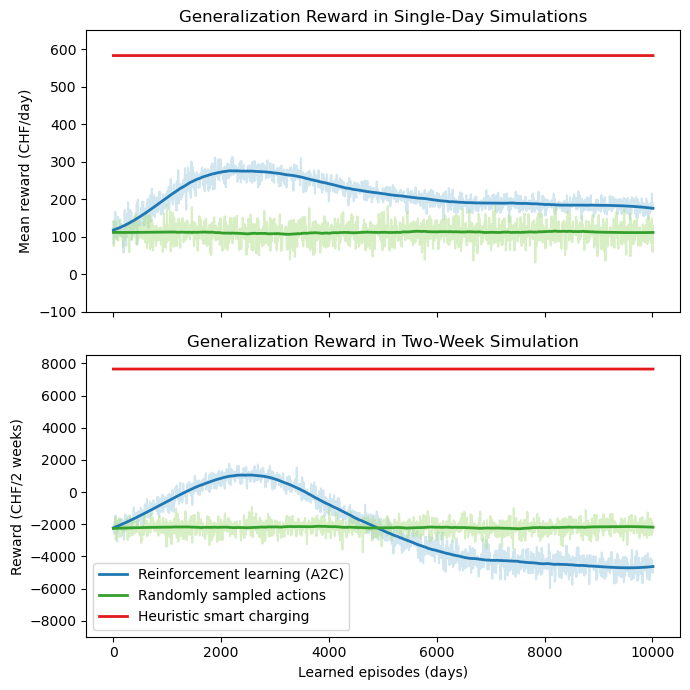

In [19]:
# plot results
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 7))

# apply smoother
reward_smooth = savgol_filter(reward_list_daily, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_daily, window_length=310, polyorder=3)

# Plot data for plot 2
ax1.plot(count_list, np.array(reward_list_daily)/14, color="#a6cee3", alpha=0.5)
ax1.plot(count_list, np.array(reward_list_random_daily)/14, color="#b2df8a", alpha=0.5)
ax1.plot(count_list, np.array(reward_smooth)/14, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=2.0)
ax1.plot(count_list, np.array(reward_random_smooth)/14, label='Randomly sampled actions', color="#33a02c", linewidth=2.0)
ax1.plot(count_list, np.array(reward_list_smart_charging_daily)/14, label='Analytical smart charging', color="#e31a1c", linewidth=2.0)
ax1.set_title("Generalization Reward in Single-Day Simulations")
ax1.set_ylabel('Mean reward (CHF/day)')
ax1.set_ylim(-100, 650)

# apply smoother
reward_smooth = savgol_filter(reward_list_long_term, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_long_term, window_length=310, polyorder=3)

# Plot data for plot 1
ax2.plot(count_list, reward_list_long_term, color="#a6cee3", alpha=0.5)
ax2.plot(count_list, reward_list_random_long_term, color="#b2df8a", alpha=0.5)
ax2.plot(count_list, reward_smooth, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=2.0)
ax2.plot(count_list, reward_random_smooth, label='Randomly sampled actions', color="#33a02c", linewidth=2.0)
ax2.plot(count_list, reward_list_smart_charging_long_term, label='Heuristic smart charging', color="#e31a1c", linewidth=2.0)
ax2.set_title("Generalization Reward in Two-Week Simulation")
ax2.set_ylabel('Reward (CHF/2 weeks)')
ax2.set_ylim(-9000, 8500)
ax2.legend(loc="lower left")
ax2.set_xlabel('Learned episodes (days)')

plt.tight_layout()
plt.show()

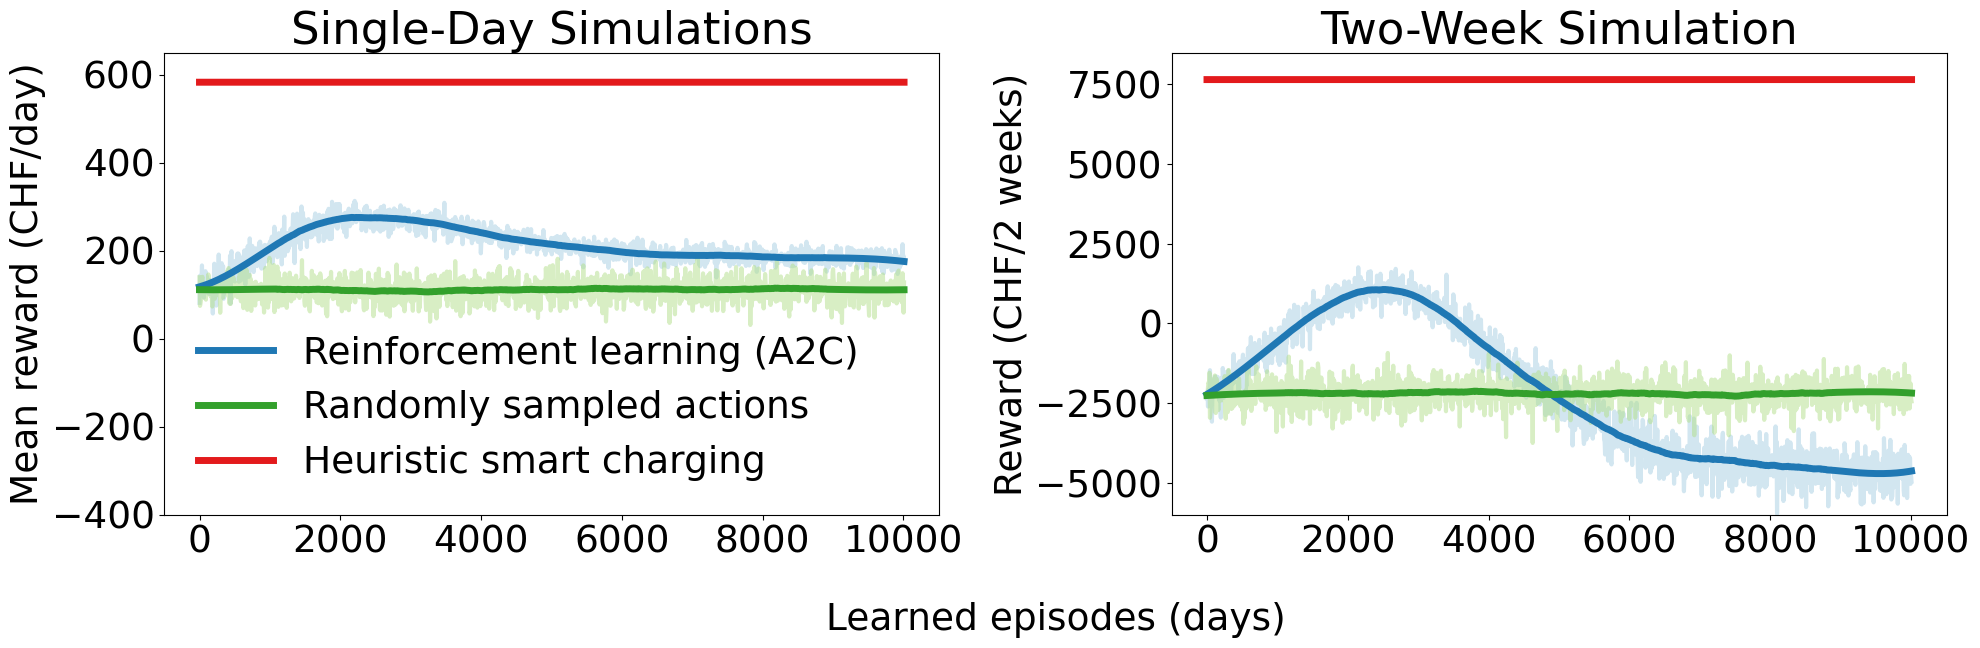

In [20]:
# Plot for poster

# Set font size
plt.rcParams.update({'font.size': 27, 'font.weight': 'medium'})
# Adjust figure dimensions
plt.figure(figsize=(23, 6))

# Plot 1
reward_smooth = savgol_filter(reward_list_long_term, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_long_term, window_length=310, polyorder=3)

# Create the first subplot
plt.subplot(1, 2, 2)
plt.plot(count_list, reward_list_long_term, color="#a6cee3", alpha=0.5, linewidth=3.0)
plt.plot(count_list, reward_list_random_long_term, color="#b2df8a", alpha=0.5, linewidth=3.0)
plt.plot(count_list, reward_smooth, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=5.0)
plt.plot(count_list, reward_random_smooth, label='Randomly sampled actions', color="#33a02c", linewidth=5.0)
plt.plot(count_list, reward_list_smart_charging_long_term, label='Analytical smart charging', color="#e31a1c", linewidth=5.0)
plt.title("Two-Week Simulation", fontweight='medium')
plt.ylabel('Reward (CHF/2 weeks)')
xlabel = plt.xlabel('Learned episodes (days)', labelpad=30)
xlabel.set_x(-0.15)
plt.ylim(-6000, 8500)
# Get the current Axes object
ax = plt.gca()

# Set the plot background color to white
ax.set_facecolor('white')


# Plot 2
reward_smooth = savgol_filter(reward_list_daily, window_length=310, polyorder=3)
reward_random_smooth = savgol_filter(reward_list_random_daily, window_length=310, polyorder=3)

# Create the second subplot
plt.subplot(1, 2, 1)
plt.plot(count_list, np.array(reward_list_daily)/14, color="#a6cee3", alpha=0.5, linewidth=3.0)
plt.plot(count_list, np.array(reward_list_random_daily)/14, color="#b2df8a", alpha=0.5, linewidth=3.0)
plt.plot(count_list, np.array(reward_smooth)/14, label='Reinforcement learning (A2C)', color="#1f78b4", linewidth=5.0)
plt.plot(count_list, np.array(reward_random_smooth)/14, label='Randomly sampled actions', color="#33a02c", linewidth=5.0)
plt.plot(count_list, np.array(reward_list_smart_charging_daily)/14, label='Heuristic smart charging', color="#e31a1c", linewidth=5.0)
plt.title("Single-Day Simulations", fontweight='medium')
plt.ylabel('Mean reward (CHF/day)')
plt.ylim(-400, 650)
plt.legend(loc="lower left")

plt.legend(frameon=False)

# Get the current Axes object
ax = plt.gca()

# Set the plot background color to white
ax.set_facecolor('white')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)


# Show the plots
plt.savefig('Results/case_study_poster.png', dpi=500, transparent=True)
plt.show()
